In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# hyper-parameters
learning_rate = 0.001  # The optimization learning rate
epochs = 10  # Total number of training epochs
batch_size = 100  # Training batch size
display_freq = 100  # Frequency of displaying the training results

# Network Parameters
# We know that MNIST images are 28 pixels in each dimension.
img_h = img_w = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_h * img_w

# Number of classes, one class for each of 10 digits.
n_classes = 10

# number of units in the first hidden layer
h1 = 200

In [4]:
def plot_example_errors(images, cls_true, cls_pred):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


def plot_images(images, cls_true, cls_pred=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    img_h = img_w = np.sqrt(images.shape[-1]).astype(int)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_h, img_w)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            title = "True: {0}".format(cls_true[i])
        else:
            title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [5]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    name: weight name
    shape: weight shape
    
    return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    name: bias variable name
    shape: bias variable shape
    
    return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)


def fc_layer(x, num_nodes, name, use_relu=True):
    """
    Creates a fully-connected layer
    :param x: input from previous layer
    :param num_nodes: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    
    :return: The output array
    """
    in_dim = x.get_shape()[1]
    W = weight_variable(name, shape=[in_dim, num_nodes])
    b = bias_variable(name, [num_nodes])
    layer = tf.matmul(x, W)
    layer += b
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [6]:
# Create graph
# Placeholders for inputs (x), outputs(y)
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
fc1 = fc_layer(x, h1, 'FC1', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'OUT', use_relu=False)

# Define the loss function, optimizer, and accuracy
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Network predictions
cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')

# Initializing the variables
init = tf.global_variables_initializer()

In [7]:
# Launch the graph (session)
sess = tf.InteractiveSession()
sess.run(init)
num_tr_iter = int(mnist.train.num_examples / batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch))
    for iter in range(num_tr_iter):
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop)
        _, loss_batch, acc = sess.run([optimizer, loss, accuracy],
                                      feed_dict={x: batch_x, y: batch_y})

        if iter % display_freq == 0:
            # Calculate batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict={x: batch_x, y: batch_y})
            print("iter {}:\t Loss={:.2f},\tTraining Accuracy={:.2f}".
                  format(iter, loss_batch, acc_batch))

    # validation
    loss_valid, acc_valid = sess.run([loss, accuracy],
                                     feed_dict={x: mnist.validation.images,
                                                y: mnist.validation.labels})
    print("Validation Accuracy:",
          sess.run(accuracy, feed_dict={x: mnist.validation.images,
                                        y: mnist.validation.labels}))

Training epoch: 0
iter 0:	 Loss=2.28,	Training Accuracy=0.74
iter 100:	 Loss=0.34,	Training Accuracy=0.91
iter 200:	 Loss=0.44,	Training Accuracy=0.84
iter 300:	 Loss=0.23,	Training Accuracy=0.95
iter 400:	 Loss=0.38,	Training Accuracy=0.93
iter 500:	 Loss=0.34,	Training Accuracy=0.91
Validation Accuracy: 0.9456
Training epoch: 1
iter 0:	 Loss=0.15,	Training Accuracy=0.96
iter 100:	 Loss=0.25,	Training Accuracy=0.93
iter 200:	 Loss=0.16,	Training Accuracy=0.96
iter 300:	 Loss=0.16,	Training Accuracy=0.94
iter 400:	 Loss=0.15,	Training Accuracy=0.95
iter 500:	 Loss=0.13,	Training Accuracy=0.97
Validation Accuracy: 0.9622
Training epoch: 2
iter 0:	 Loss=0.14,	Training Accuracy=0.97
iter 100:	 Loss=0.06,	Training Accuracy=1.00
iter 200:	 Loss=0.11,	Training Accuracy=0.97
iter 300:	 Loss=0.08,	Training Accuracy=0.99
iter 400:	 Loss=0.09,	Training Accuracy=0.97
iter 500:	 Loss=0.07,	Training Accuracy=0.98
Validation Accuracy: 0.9674
Training epoch: 3
iter 0:	 Loss=0.09,	Training Accuracy=0.

Testing Accuracy: 0.9785


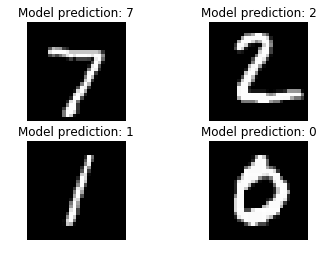

In [8]:
# test the network
# Calculate accuracy
print("Testing Accuracy:",
      sess.run(accuracy, feed_dict={x: mnist.test.images,
                                    y: mnist.test.labels}))
# Predict single images
n_images = 4
test_images = mnist.test.images[:n_images]
preds = sess.run(cls_prediction, feed_dict={x: test_images})
# Display
fig = plt.figure()
for i in range(n_images):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    ax.set_title("Model prediction: {}".format(preds[i]))
    ax.axis('off')
plt.show()
sess.close()